In [15]:
import skimage.data 
import numpy as np
import matplotlib.pyplot as plt

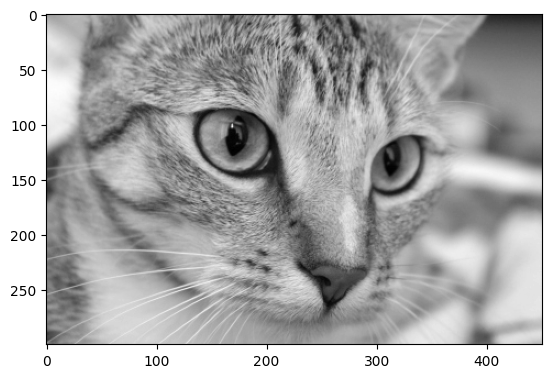

In [16]:
 # Reading the image  
img = skimage.data.chelsea()  
# Converting the image into gray.  
img = skimage.color.rgb2gray(img)
plt.imshow(img, cmap='gray')

In [17]:
l1_filter = np.zeros((2,3,3))

l1_filter[0, :, :] = np.array([[[-1, 0, 1],   
                                   [-1, 0, 1],   
                                   [-1, 0, 1]]])  
l1_filter[1, :, :] = np.array([[[1,   1,  1],   
                                   [0,   0,  0],   
                                   [-1, -1, -1]]]) 

In [18]:
def conv(img, conv_filter):  
    if len(img.shape) > 2 or len(conv_filter.shape) > 3:  # Check if number of image channels matches the filter depth.  
        if img.shape[-1] != conv_filter.shape[-1]:  
            print("Error: Number of channels in both image and filter must match.")  
            sys.exit()  
    
    if conv_filter.shape[1] != conv_filter.shape[2]:  # Check if filter dimensions are equal.  
        print('Error: Filter must be a square matrix. I.e. number of rows and columns must match.')  
        sys.exit()  
    
    if conv_filter.shape[1] % 2 == 0:  # Check if filter dimensions are odd.  
        print('Error: Filter must have an odd size. I.e. number of rows and columns must be odd.')  
        sys.exit()  
    
    # An empty feature map to hold the output of convolving the filter(s) with the image.  
    feature_maps = np.zeros((img.shape[0] - conv_filter.shape[1] + 1,   
                                img.shape[1] - conv_filter.shape[1] + 1,   
                                conv_filter.shape[0]))  
    
    # Convolving the image by the filter(s).  
    for filter_num in range(conv_filter.shape[0]):  
        print("Filter ", filter_num + 1)  
        curr_filter = conv_filter[filter_num, :]  # Getting a filter from the bank.  
        
        """  
        Checking if there are multiple channels for the single filter. 
        If so, then each channel will convolve the image. 
        The result of all convolutions are summed to return a single feature map. 
        """  
        if len(curr_filter.shape) > 2:  
            conv_map = conv_(img[:, :, 0], curr_filter[:, :, 0])  # Array holding the sum of all feature maps.  
            for ch_num in range(1, curr_filter.shape[-1]):  # Convolving each channel with the image and summing the results.  
                conv_map = conv_map + conv_(img[:, :, ch_num], curr_filter[:, :, ch_num])  
        else:  # There is just a single channel in the filter.  
            conv_map = conv_(img, curr_filter)  
    
        feature_maps[:, :, filter_num] = conv_map  # Holding feature map with the current filter.
    
    return feature_maps  # Returning all feature maps.


In [19]:
def conv_(img, conv_filter):  
    filter_size = conv_filter.shape[0]  
    result = np.zeros((img.shape))  
    
    # Looping through the image to apply the convolution operation.  
    for r in np.uint16(np.arange(filter_size / 2, img.shape[0] - filter_size / 2 - 2)):  
        for c in np.uint16(np.arange(filter_size / 2, img.shape[1] - filter_size / 2 - 2)):  
            # Getting the current region to get multiplied with the filter.  
            curr_region = img[r:r + filter_size, c:c + filter_size]  
            
            # Element-wise multiplication between the current region and the filter.  
            curr_result = curr_region * conv_filter  
            conv_sum = np.sum(curr_result)  # Summing the result of multiplication.  
            result[r, c] = conv_sum  # Saving the summation in the convolution layer feature map.  
    
    # Clipping the outliers of the result matrix.  
    final_result = result[np.uint16(filter_size / 2):result.shape[0] - np.uint16(filter_size / 2),   
                          np.uint16(filter_size / 2):result.shape[1] - np.uint16(filter_size / 2)]  
    
    return final_result


In [20]:
l1_feature_map = conv(img, l1_filter)

Filter  1
Filter  2


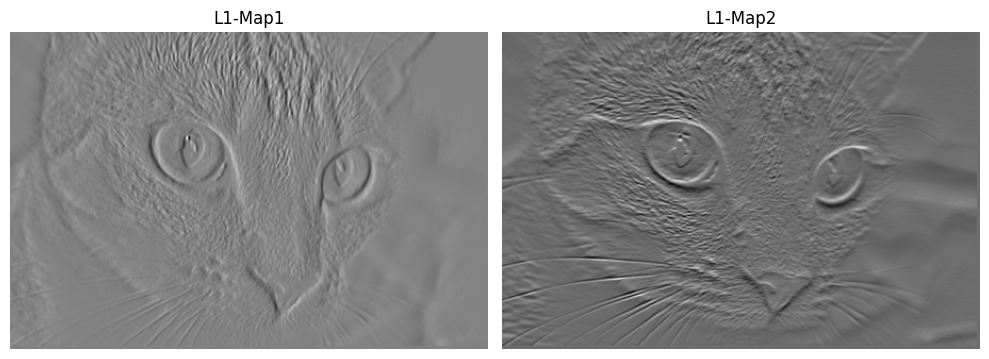

In [21]:
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.imshow(l1_feature_map[:, :, 0], cmap='gray')
plt.title("L1-Map1")
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(l1_feature_map[:, :, 1], cmap='gray')
plt.title("L1-Map2")
plt.axis('off')

plt.tight_layout()
plt.show()


In [23]:
def relu(feature_map):
    # Preparing the output of the ReLU activation function.
    relu_out = np.zeros(feature_map.shape)
    
    # Looping through each feature map and applying ReLU element-wise.
    for map_num in range(feature_map.shape[-1]):
        for r in np.arange(0, feature_map.shape[0]):
            for c in np.arange(0, feature_map.shape[1]):
                relu_out[r, c, map_num] = np.max([feature_map[r, c, map_num], 0])
    
    return relu_out

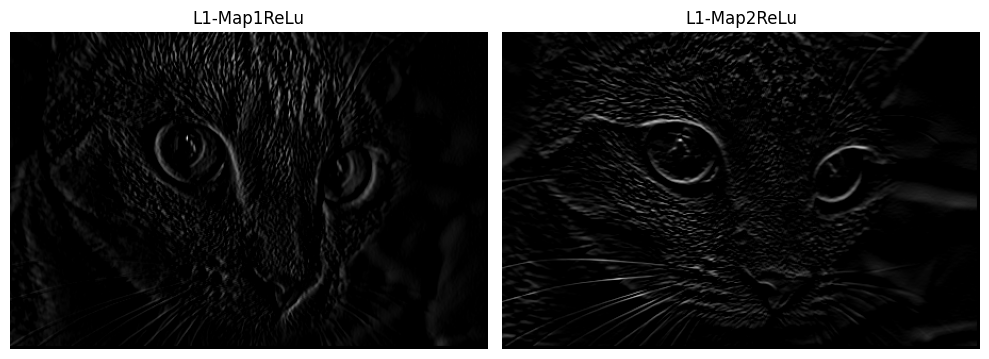

In [24]:
l1_feature_map_relu = relu(l1_feature_map)

plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.imshow(l1_feature_map_relu[:, :, 0], cmap='gray')
plt.title("L1-Map1ReLu")
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(l1_feature_map_relu[:, :, 1], cmap='gray')
plt.title("L1-Map2ReLu")
plt.axis('off')

plt.tight_layout()
plt.show()

In [25]:
def pooling(feature_map, size=2, stride=2):
    # Preparing the output of the pooling operation.
    pool_out = np.zeros((np.uint16((feature_map.shape[0] - size + 1) / stride),
                         np.uint16((feature_map.shape[1] - size + 1) / stride),
                         feature_map.shape[-1]))
    
    for map_num in range(feature_map.shape[-1]):
        r2 = 0
        for r in np.arange(0, feature_map.shape[0] - size - 1, stride):
            c2 = 0
            for c in np.arange(0, feature_map.shape[1] - size - 1, stride):
                pool_out[r2, c2, map_num] = np.max(feature_map[r:r+size, c:c+size])
                c2 = c2 + 1
            r2 = r2 + 1
    
    return pool_out


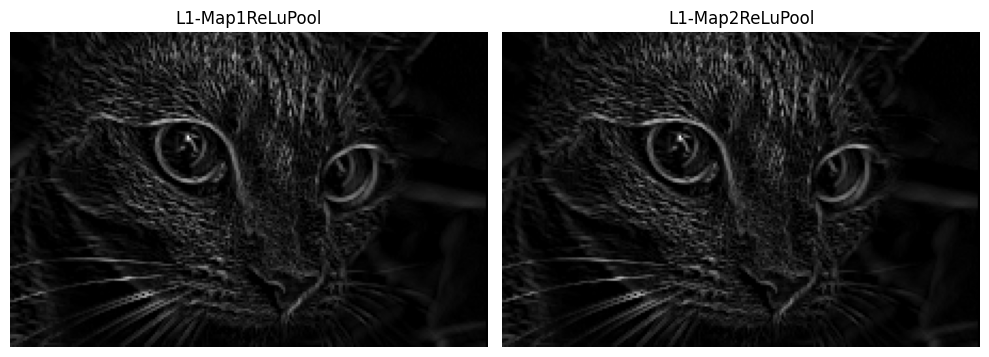

In [27]:
l1_feature_map_relu_pool = pooling(l1_feature_map_relu, 2, 2)

plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.imshow(l1_feature_map_relu_pool[:, :, 0], cmap='gray')
plt.title("L1-Map1ReLuPool")
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(l1_feature_map_relu_pool[:, :, 1], cmap='gray')
plt.title("L1-Map2ReLuPool")
plt.axis('off')

plt.tight_layout()
plt.show()

In [28]:
# Second conv layer
l2_filter = np.random.rand(3, 5, 5, l1_feature_map_relu_pool.shape[-1])  
print("\n**Working with conv layer 2**")

l2_feature_map = conv(l1_feature_map_relu_pool, l2_filter)  
print("\n**ReLU**")

l2_feature_map_relu = relu(l2_feature_map)  
print("\n**Pooling**")

l2_feature_map_relu_pool = pooling(l2_feature_map_relu, 2, 2)  
print("**End of conv layer 2**\n")



**Working with conv layer 2**
Filter  1
Filter  2
Filter  3

**ReLU**

**Pooling**
**End of conv layer 2**



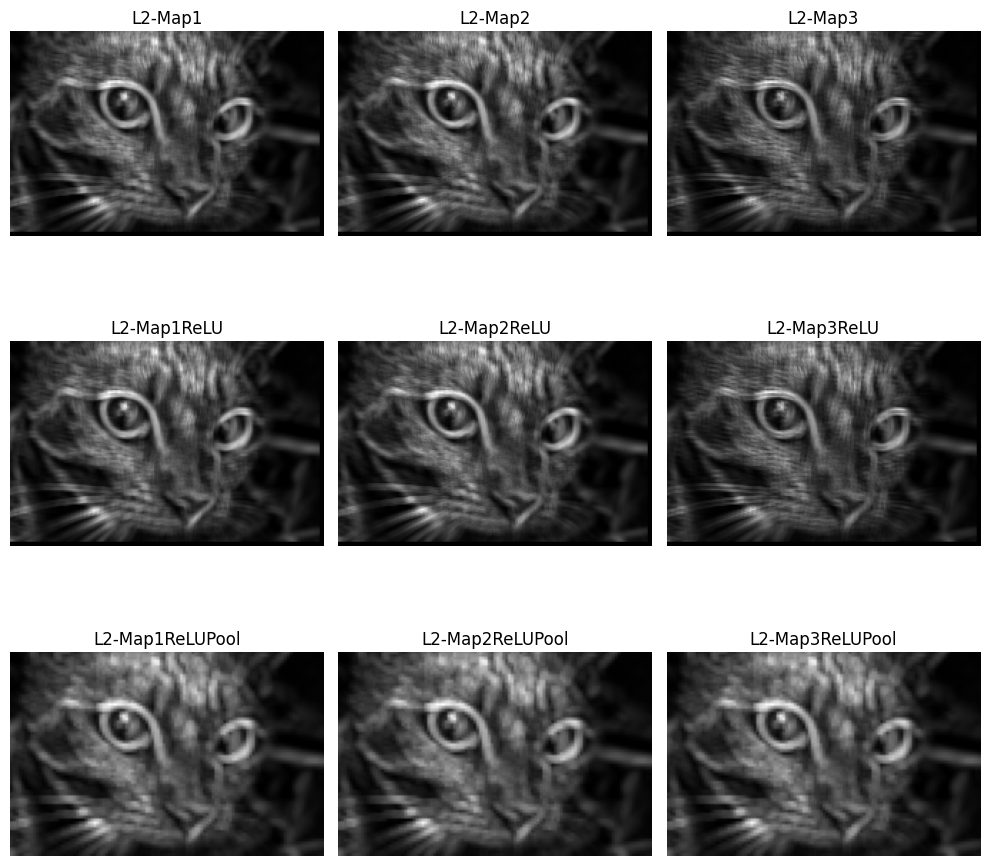

In [29]:
fig, axes = plt.subplots(3, 3, figsize=(10, 10))  # 3x3 grid

# First row: Convolution output (L2-Map1, L2-Map2, L2-Map3)
for i in range(3):
    axes[0, i].imshow(l2_feature_map[:, :, i], cmap='gray')
    axes[0, i].set_title(f"L2-Map{i+1}")
    axes[0, i].axis('off')

# Second row: ReLU applied to convolution output (L2-Map1ReLU, L2-Map2ReLU, L2-Map3ReLU)
for i in range(3):
    axes[1, i].imshow(l2_feature_map_relu[:, :, i], cmap='gray')
    axes[1, i].set_title(f"L2-Map{i+1}ReLU")
    axes[1, i].axis('off')

# Third row: Pooled feature maps after ReLU (L2-Map1ReLUPool, L2-Map2ReLUPool, L2-Map3ReLUPool)
for i in range(3):
    axes[2, i].imshow(l2_feature_map_relu_pool[:, :, i], cmap='gray')
    axes[2, i].set_title(f"L2-Map{i+1}ReLUPool")
    axes[2, i].axis('off')

# Adjust layout
plt.tight_layout()
plt.show()



**Working with conv layer 3**
Filter  1

**ReLU**

**Pooling**
**End of conv layer 3**



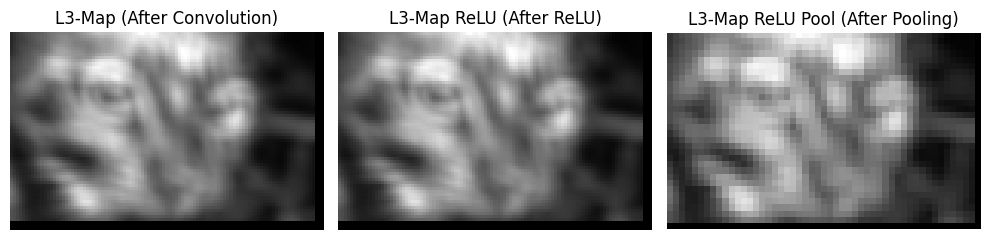

In [30]:
# Third conv layer
l3_filter = np.random.rand(1, 7, 7, l2_feature_map_relu_pool.shape[-1])  # One filter of size 7x7
print("\n**Working with conv layer 3**")

l3_feature_map = conv(l2_feature_map_relu_pool, l3_filter)
print("\n**ReLU**")

l3_feature_map_relu = relu(l3_feature_map)
print("\n**Pooling**")

l3_feature_map_relu_pool = pooling(l3_feature_map_relu, 2, 2)
print("**End of conv layer 3**\n")

# Plotting the results
plt.figure(figsize=(10, 5))

# Plot L3-Map (After Convolution)
plt.subplot(1, 3, 1)
plt.imshow(l3_feature_map[:, :, 0], cmap='gray')  # Since there's only one filter, it's 2D
plt.title("L3-Map (After Convolution)")
plt.axis('off')

# Plot L3-Map ReLU (After ReLU)
plt.subplot(1, 3, 2)
plt.imshow(l3_feature_map_relu[:, :, 0], cmap='gray')
plt.title("L3-Map ReLU (After ReLU)")
plt.axis('off')

# Plot L3-Map ReLU Pool (After Pooling)
plt.subplot(1, 3, 3)
plt.imshow(l3_feature_map_relu_pool[:, :, 0], cmap='gray')
plt.title("L3-Map ReLU Pool (After Pooling)")
plt.axis('off')

# Adjust layout and show plots
plt.tight_layout()
plt.show()
